In [11]:
%load_ext autoreload
%autoreload 2
import logging

logging.getLogger('mat73').setLevel(logging.CRITICAL)
import os
import re
from scipy.io import loadmat
import mat73
logging.getLogger('mat73').setLevel(logging.CRITICAL)

import warnings

from collections import Counter
import pandas as pd
import numpy as np
from scipy.stats import f_oneway

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

from utils import *
from connectivity_dynamics import *
from eibal import *

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Exploring the Structs with PDC Welch 
Here we will use the pre-computed spectral decompositions to plot the frequency range that most tracks E/I balance.
    According to the Voytek group this is the 30-50Hz range
    

In [42]:
DATA_DIR = '/mnt/ernie_main/Ghassan/ephys/data/connectivity'
SUB_DIR = 'Epat09'
sub_paths= glob.glob(os.path.join(DATA_DIR, SUB_DIR, "*PDC.mat"))
sub_paths

['/mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat09/Epat09_10_Focal,_unknown_awareness_PDC.mat',
 '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat09/Epat09_16_Focal,_unknown_awareness_PDC.mat',
 '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat09/Epat09_1_Focal,_unknown_awareness_PDC.mat',
 '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat09/Epat09_2_FIAS_PDC.mat',
 '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat09/Epat09_3_FAS_PDC.mat',
 '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat09/Epat09_4_FIAS_PDC.mat',
 '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat09/Epat09_5_FIAS_PDC.mat',
 '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat09/Epat09_8_FBTC_PDC.mat',
 '/mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat09/Epat09_9_Focal,_unknown_awareness_PDC.mat']

In [46]:
i=5
print(sub_paths[i])
tst_struct = load_mat(sub_paths[i])

/mnt/ernie_main/Ghassan/ephys/data/connectivity/Epat09/Epat09_4_FIAS_PDC.mat


In [57]:
set(read_conn_struct(tst_struct, 'pdc','soz_per_seizure'))
bip

array(['RH1RH2', 'RH2RH3', 'RH4RH5', 'RH5RH6', 'RH6RH7', 'RH7RH8',
       'RH8RH9', 'RH9RH10', 'RAMY1RAMY2', 'RAMY2RAMY3', 'RAMY3RAMY4',
       'RAMY8RAMY9', 'RAC1RAC2', 'RAC2RAC3', 'RAC3RAC4', 'RAC5RAC6',
       'RAC6RAC7', 'RAC7RAC8', 'RAC8RAC9', 'RAC9RAC10', 'RFP1RFP2',
       'RFP2RFP3', 'RFP4RFP5', 'RFP5RFP6', 'RFP6RFP7', 'RFP7RFP8',
       'RFP8RFP9', 'RFP9RFP10', 'RTP2RTP3', 'RTP3RTP4', 'RTP4RTP5',
       'RTP7RTP8', 'RILT1RILT2', 'RILT3RILT4', 'RILT6RILT7', 'RILT7RILT8',
       'RILT8RILT9', 'RILT9RILT10', 'RANG1RANG2', 'RANG2RANG3',
       'RANG4RANG5', 'RANG5RANG6', 'RANG6RANG7', 'RANG7RANG8',
       'RANG8RANG9', 'RS7RS8', 'RS8RS9', 'LH1LH2', 'LH2LH3', 'LH3LH4',
       'LH8LH9', 'LH9LH10', 'LAMY1LAMY2', 'LAMY2LAMY3', 'LAMY3LAMY4',
       'LAMY7LAMY8', 'LAMY8LAMY9', 'LAMY9LAMY10', 'LAC1LAC2', 'LAC2LAC3',
       'LAC4LAC5', 'LAC5LAC6', 'LAC6LAC7', 'LAC7LAC8', 'LAC8LAC9'],
      dtype='<U11')

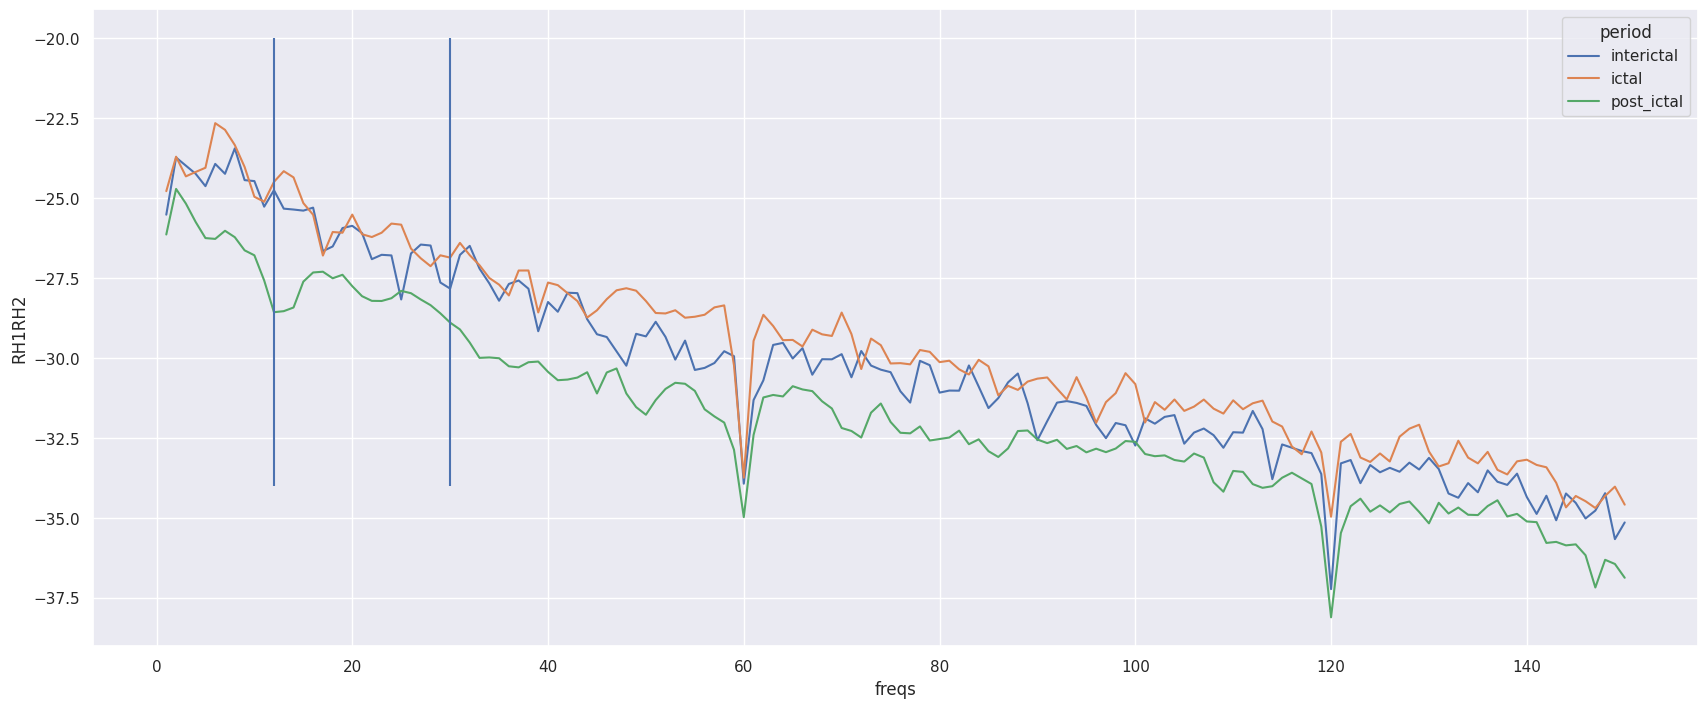

In [59]:
bip = get_chan_names(tst_struct)
pwelch_all_windows = read_conn_struct(tst_struct, 'pdc','pwelch_all_windowed')
freqs = read_conn_struct(tst_struct, 'pdc','pwelch_freqs')
psd_dfs = []
for period, win in zip(['interictal','ictal','post_ictal'],[0, 600, -1]):
    first_window = pwelch_all_windows[win,:,:]
    first_window.shape
    psd_df = pd.DataFrame(data=np.log(first_window.T),columns=bip)
    psd_df['freqs'] = freqs
    psd_df['period'] = period
    psd_dfs.append(psd_df)
psd_dfs = pd.concat(psd_dfs)


ax = sns.lineplot(data=psd_dfs, x='freqs', y='RH1RH2',hue='period')
ax.vlines(BAND_RANGES['beta'], ymin=-34, ymax=-20)



In [11]:
psd = np.log(first_window)
psd.shape

freq ='beta'
lo, hi = BAND_RANGES[freq]
inds_h = np.where(freqs <= hi)
inds_l = np.where(freqs > lo)
inds  = np.intersect1d(inds_h, inds_l)
widths = np.diff(freqs) #NOTE: that this may be off by 1!



In [50]:
df = assemble_psd_verbose(tst_struct, sz_band=['beta','delta'])
df

region eventID sz_type   patID       bip  period window_designations  \
0     SOZ       4    FIAS  Epat09    RH1RH2       0         0.0_0.0_0.0   
1     SOZ       4    FIAS  Epat09    RH2RH3       0         0.0_0.0_0.0   
2     NIZ       4    FIAS  Epat09    RH4RH5       0         0.0_0.0_0.0   
3     NIZ       4    FIAS  Epat09    RH5RH6       0         0.0_0.0_0.0   
4     NIZ       4    FIAS  Epat09    RH6RH7       0         0.0_0.0_0.0   
..    ...     ...     ...     ...       ...     ...                 ...   
60    NIZ       4    FIAS  Epat09  LAC4LAC5    1309         2.0_2.0_2.0   
61    NIZ       4    FIAS  Epat09  LAC5LAC6    1309         2.0_2.0_2.0   
62    NIZ       4    FIAS  Epat09  LAC6LAC7    1309         2.0_2.0_2.0   
63    NIZ       4    FIAS  Epat09  LAC7LAC8    1309         2.0_2.0_2.0   
64    NIZ       4    FIAS  Epat09  LAC8LAC9    1309         2.0_2.0_2.0   

    power_beta    z_beta  frac_change_beta  power_delta   z_delta  \
0  -476.141216  1.791795          5.124757   -97.452752  1.360518   
1  -455.716428  1.603267          6.223981   -96.216735  0.725795   
2  -499.839376  0.372280          0.458193   -93.760773  0.921338   
3  -493.039770 -1.105821         -1.064748   -95.572451  0.411339   
4  -489.026712 -0.564770         -1.098818   -99.769520 -0.616893   
..         ...       ...               ...          ...       ...   
60 -502.935828  2.005228          1.351949  -103.121160  2.949349   
61 -487.889956 -2.877846         -2.245318  -100.151677 -2.204262   
62 -484.722268 -0.823091         -0.626412   -99.444490  0.082843   
63 -487.837441 -0.871245         -0.747122  -101.180783  1.410086   
64 -506.585556 -1.726786         -1.904470  -104.198638  0.280143   

    frac_change_delta  
0            4.320526  
1            2.607948  
2            2.099517  
3            0.952264  
4           -1.708682  
..                ...  
60           3.625820  
61          -2.993911  
62           0.121160  
63           1.769623  
64           0.534744  

[85150 rows x 13 columns]

In [39]:
df[df.region=='SOZ']

region eventID sz_type   patID        bip  period window_designations  \
39    SOZ       4    FIAS  Epat20   AIO1AIO2       0         0.0_0.0_0.0   
40    SOZ       4    FIAS  Epat20   AIO2AIO3       0         0.0_0.0_0.0   
41    SOZ       4    FIAS  Epat20   AIO3AIO4       0         0.0_0.0_0.0   
42    SOZ       4    FIAS  Epat20   AIO4AIO5       0         0.0_0.0_0.0   
43    SOZ       4    FIAS  Epat20   AIO5AIO6       0         0.0_0.0_0.0   
..    ...     ...     ...     ...        ...     ...                 ...   
58    SOZ       4    FIAS  Epat20  MIO9MIO10    1274         2.0_2.0_2.0   
69    SOZ       4    FIAS  Epat20   PIO5PIO6    1274         2.0_2.0_2.0   
70    SOZ       4    FIAS  Epat20   PIO6PIO7    1274         2.0_2.0_2.0   
71    SOZ       4    FIAS  Epat20   PIO7PIO8    1274         2.0_2.0_2.0   
72    SOZ       4    FIAS  Epat20  PIO9PIO10    1274         2.0_2.0_2.0   

    power_beta    z_beta  frac_change_beta  power_delta   z_delta  \
39 -466.119231  1.909562          1.176804   -94.196294 -0.325337   
40 -477.712479  0.661817          0.491876   -94.484983 -0.067915   
41 -479.428509  0.095336          0.103152   -90.646548  1.331923   
42 -476.834006  0.791641          0.714413   -80.047860  1.261233   
43 -487.778278  0.840454          0.474987   -88.731380  1.389048   
..         ...       ...               ...          ...       ...   
58 -488.180076 -4.244506         -7.424316   -82.789859  0.212149   
69 -497.981996 -1.196595         -1.538973   -90.809802  0.118559   
70 -473.002276 -1.854155         -2.004674   -81.533615  0.620343   
71 -471.306446 -1.507414         -1.224368   -83.632638  2.440698   
72 -468.735236 -2.318652         -1.780483   -84.563873  2.561599   

    frac_change_delta  
39          -0.492257  
40          -0.115294  
41           2.392390  
42           3.863609  
43           2.875819  
..                ...  
58           0.657716  
69           0.676618  
70           3.110285  
71           7.280020  
72           7.140615  

[24225 rows x 13 columns]

<Axes: xlabel='period', ylabel='z_beta'>

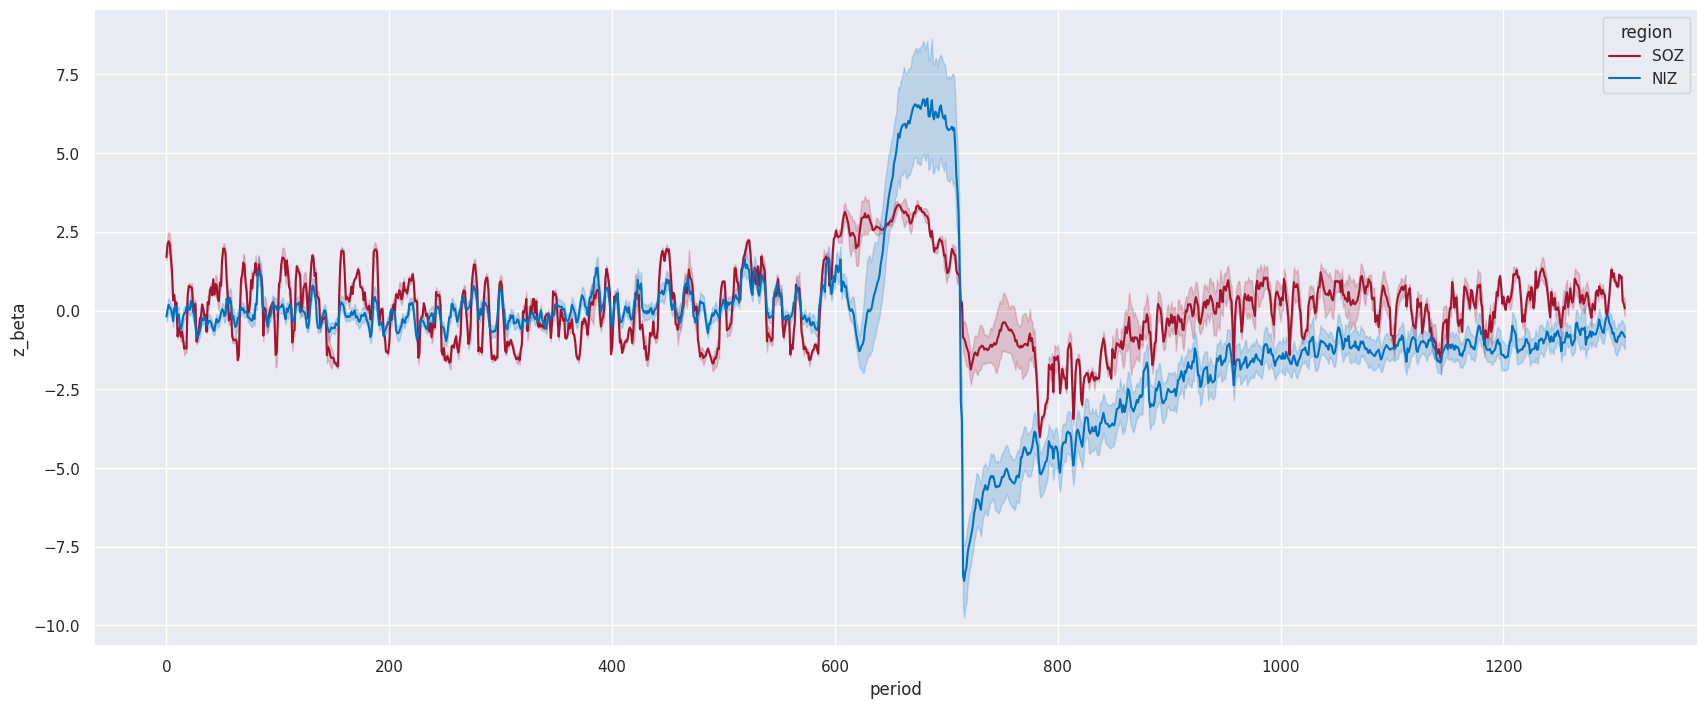

In [51]:

sns.lineplot(data=df, hue='region', x='period', y='z_beta',palette=COLOR_MAP)

<Axes: xlabel='period', ylabel='frac_change_beta'>

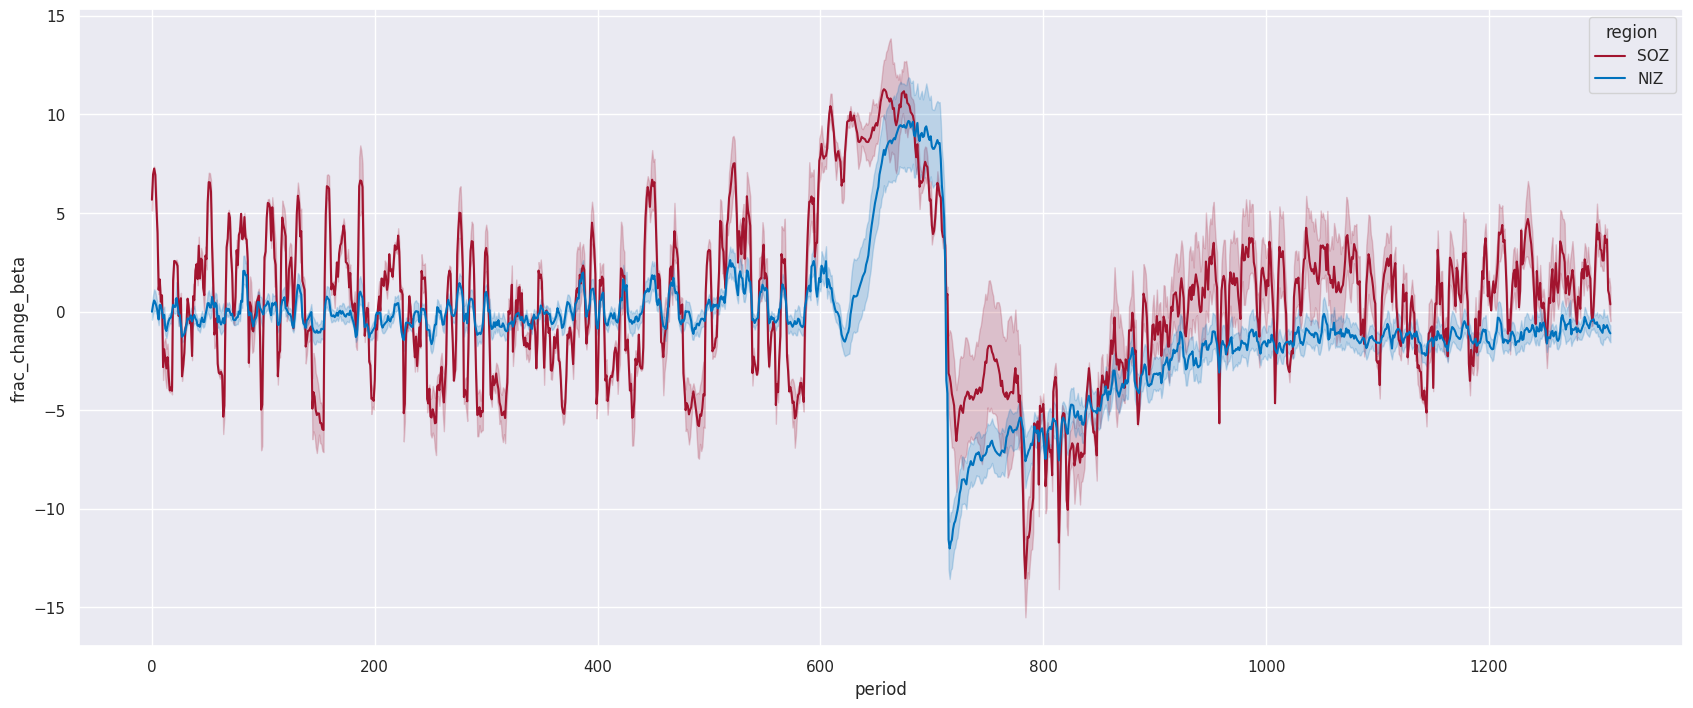

In [56]:
sns.lineplot(data=df, x='period', y='frac_change_beta',hue='region',palette=COLOR_MAP)

<Axes: xlabel='period', ylabel='z_delta'>

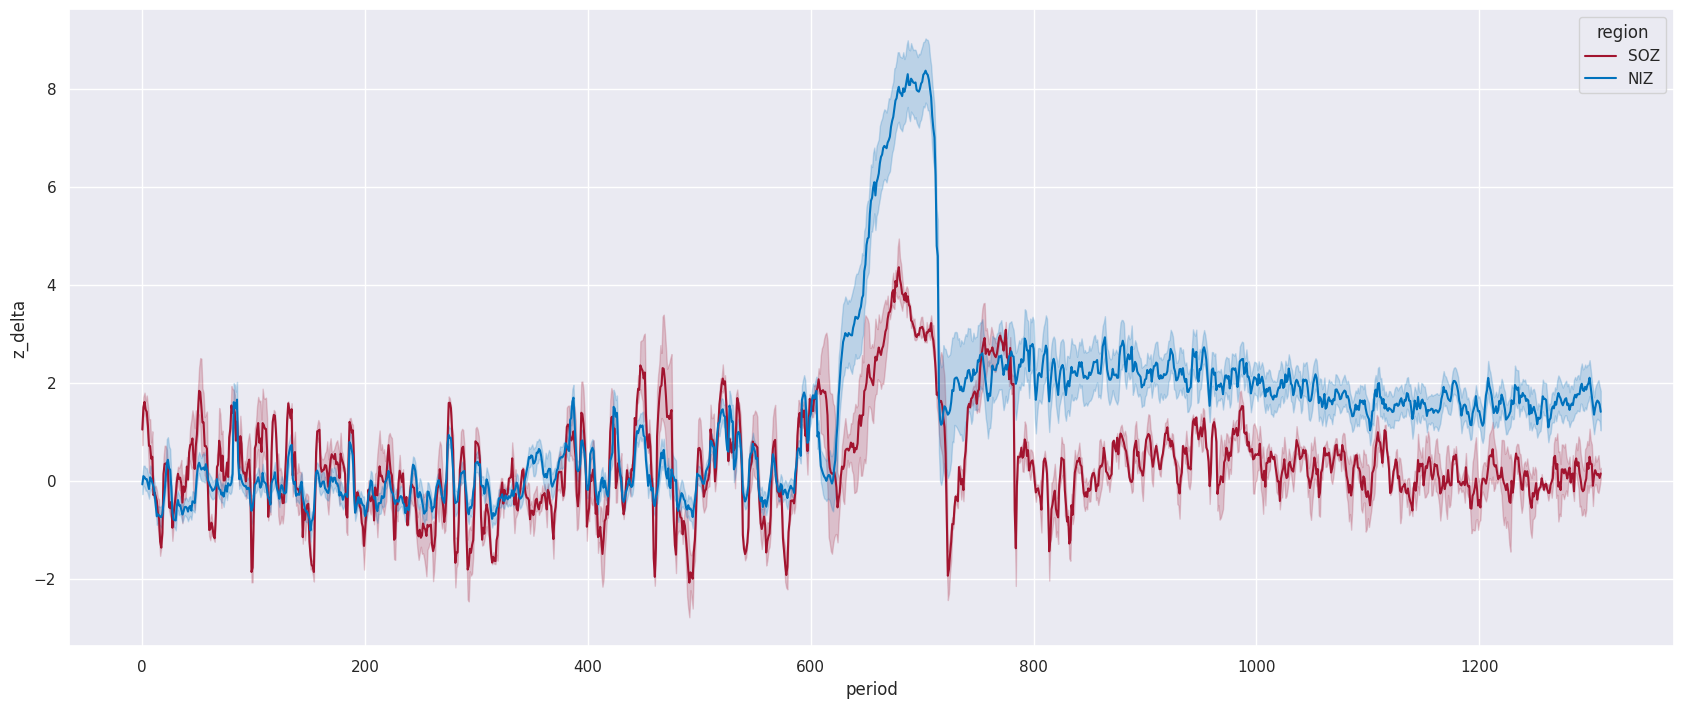

In [52]:
sns.lineplot(data=df, hue='region', x='period', y='z_delta',palette=COLOR_MAP)

<Axes: xlabel='period', ylabel='frac_change_delta'>

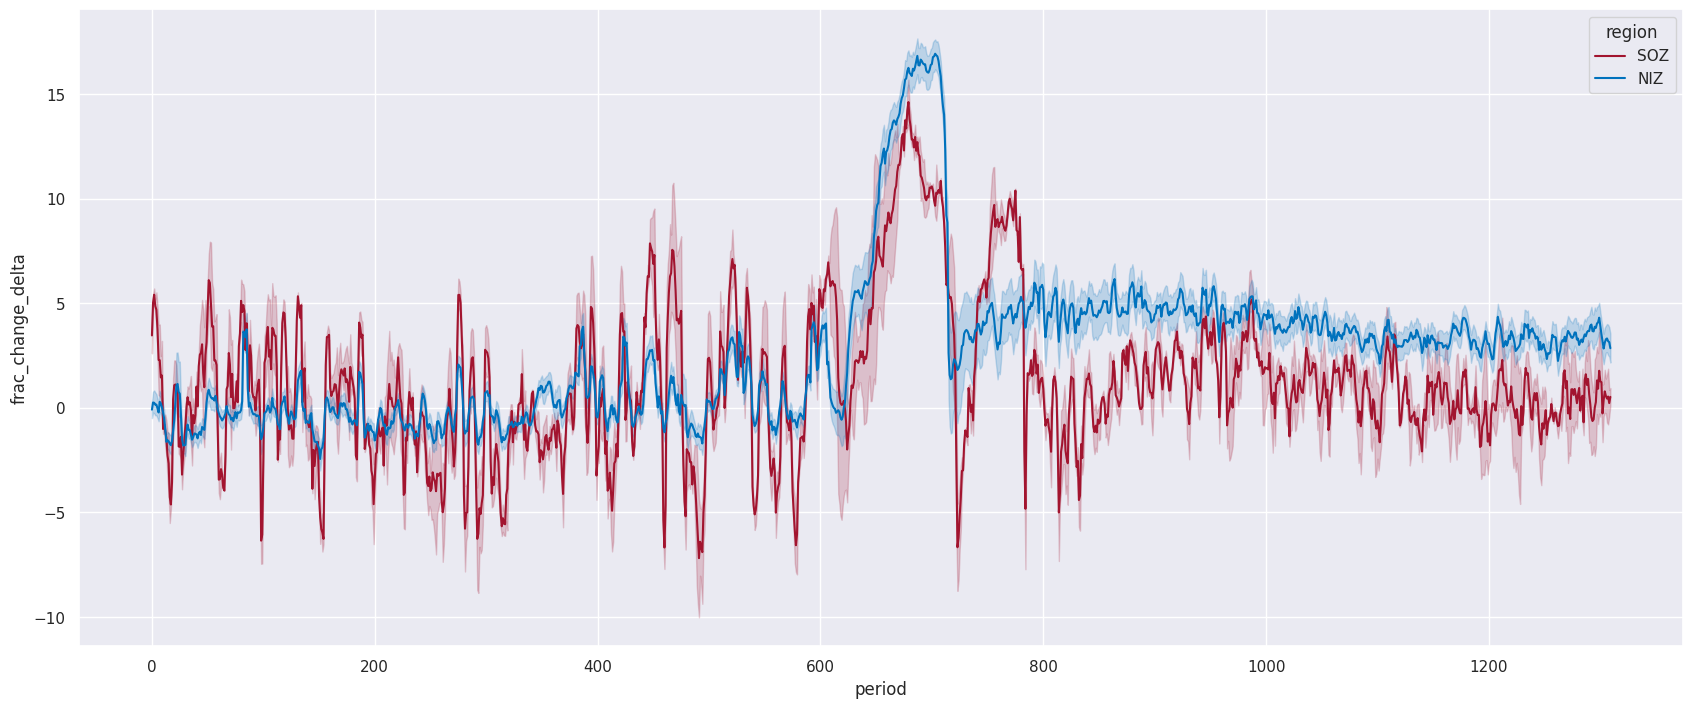

In [53]:
sns.lineplot(data=df, x='period', y='frac_change_delta',hue='region',palette=COLOR_MAP)

<Axes: xlabel='period', ylabel='z_delta'>

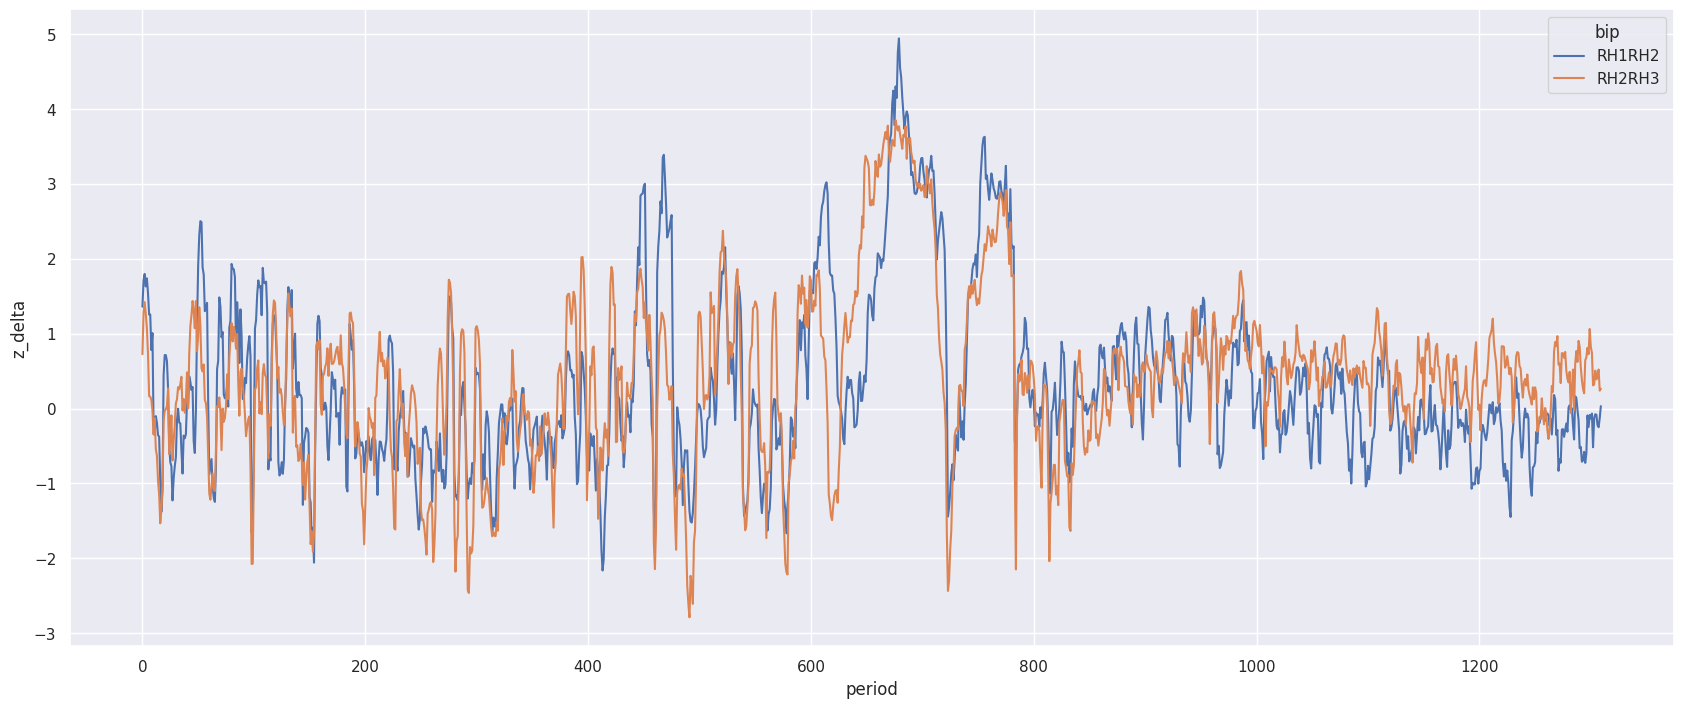

In [54]:

SOZ_df = df[df.region == 'SOZ']

sns.set_theme(rc={'figure.figsize':(20.7,8.27)})
sns.lineplot(data=SOZ_df, hue='bip', x='period', y='z_delta')

<Axes: xlabel='period', ylabel='z_delta'>

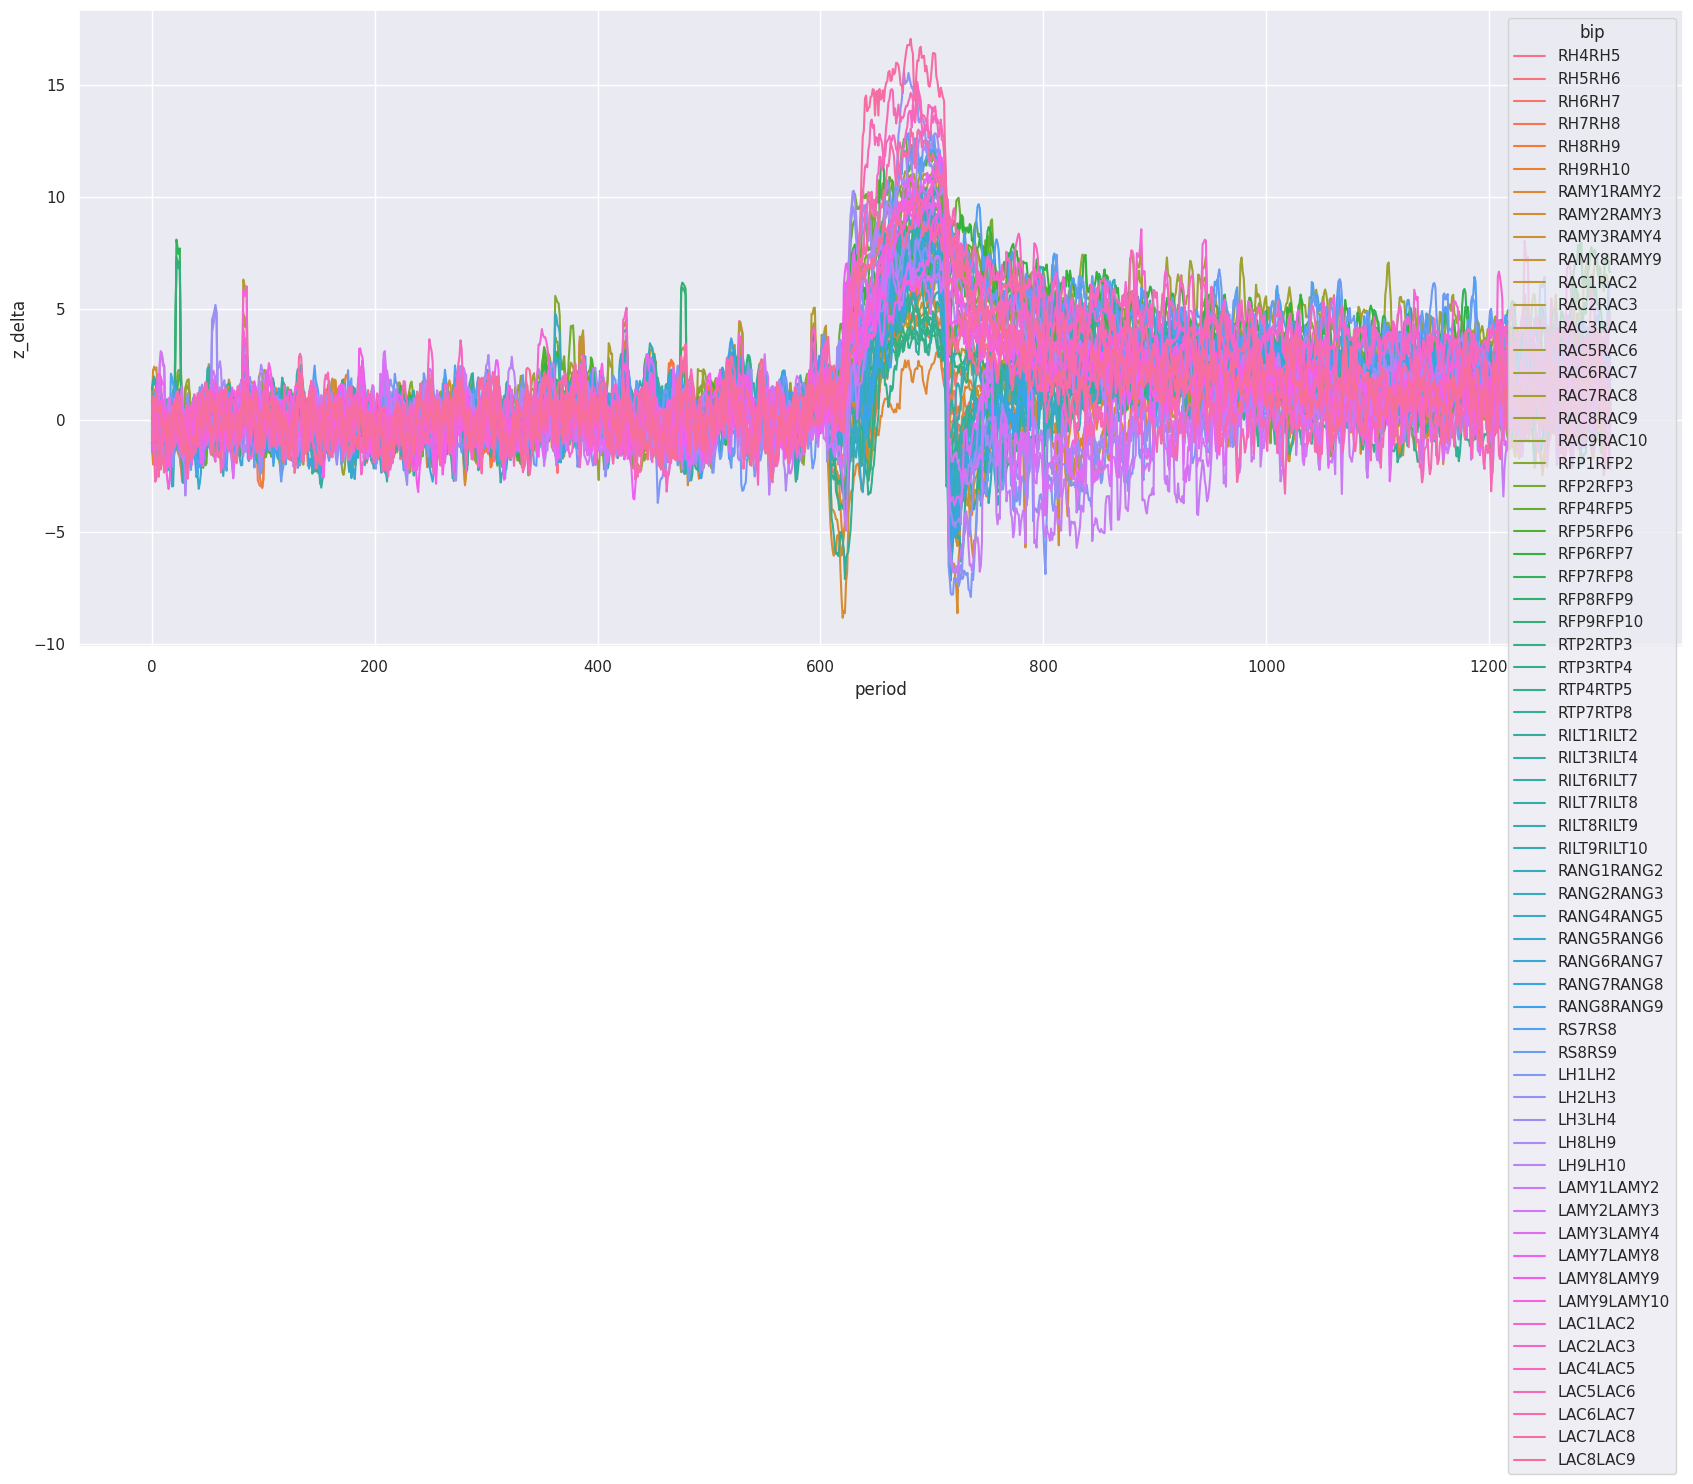

In [55]:
niz_df = df[df.region == 'NIZ']

sns.set_theme(rc={'figure.figsize':(20.7,8.27)})
sns.lineplot(data=niz_df, hue='bip', x='period', y='z_delta')


In [25]:
get_ei_slope(freqs, first_window[50,:])

np.float64(-0.0743445625577473)

In [ ]:
spectral_dfs = gen_global_peri_psd(sub_obj,spectral_keys)

In [ ]:
with sns.plotting_context("paper"):
    sns.lineplot(spectral_dfs, x="freq", y='power', hue='period')
    plt.title("Global PSD per Recording Period for Epat 31 peri-ictal Data FIAS")
    plt.xlabel("Frequency")
    plt.ylabel("log(Power)")
    plt.savefig("../viz/global_psd_Epat31_FIAS.svg",transparent=True)


In [ ]:
sub_obj['pdc']['seizure']['patID']

In [ ]:
for period in set(spectral_dfs.period):
    df = spectral_dfs[spectral_dfs.period == period]
    freqs = df.freq.values.reshape(-1,1)
    power = df.power.values.reshape(-1,1)
    slope = get_ei_slope(freqs, power)
    print(f"Period: {period} \nSlope: {slope}\n")

In [ ]:
len(sub_structs)

In [ ]:
peri_df = gen_patient_psd('Epat31', sub_structs,spectral_keys, 'gen')

In [ ]:
##Should be the same as above

with sns.plotting_context("paper"):
    sns.lineplot(peri_df, x="freq", y='power', hue='period')
    plt.title("Global PSD per Recording Period for Epat 31 peri-ictal Data FIAS")
    plt.xlabel("Frequency")
    plt.ylabel("log(Power)")
    plt.savefig("../viz/global_psd_Epat31_FIAS.svg",transparent=True)

In [ ]:
peri_df = gen_patient_psd('Epat31', sub_structs,spectral_keys, 'channel')

grp_df = peri_df.groupby(["freq",'labels','period']).mean().reset_index()

grp_df.period = grp_df.period.apply(lambda x : x.split("_")[-1])
grp_df

In [ ]:
with sns.plotting_context("paper"):
    with sns.color_palette("flare"):
        grid = sns.FacetGrid(grp_df,col='period',col_order=['interictal','pre','ictal','post']) 
        grid.map_dataframe(sns.lineplot, y='power',x='freq', hue='labels')
        grid.add_legend()
        grid.figure.suptitle("Peri Ictal PSD on a per-contact lvl",y=1.01)
        plt.savefig("../viz/peri_peri_psd.svg",transparent=True)

In [ ]:
contact_label = format_soz(sub_obj['pdc']['seizure']['soz_per_seizure'])
ei_df = get_reg_ei(sub_obj['pdc']['seizure'],spectral_keys,contact_label)
ei_df.period = ei_df.period.apply(lambda x : x.split("_")[-1])


In [ ]:
with sns.plotting_context("paper"):
    with sns.color_palette("flare"):
        grid = sns.FacetGrid(ei_df,col='period',col_order=['interictal','pre','post']) 
        grid.map_dataframe(sns.violinplot, y='e_i',x='region', hue='region')
        grid.add_legend()
        grid.figure.suptitle("Peri Ictal E/I on a per-contact lvl",y=1.01)
        plt.savefig("../viz/peri_E_I_psd.svg",transparent=True)

In [ ]:
sub_list = [sub_path.split("/")[-2] for sub_path in sub_paths]
sz_list = [sub_path.split("/")[-1].split("_")[-2] for sub_path in sub_paths]

In [ ]:
sub_paths= glob.glob(os.path.join(DATA_DIR, "*pat*", "*.mat"))


In [ ]:
# from tqdm.notebook import tqdm
# sub_paths= glob.glob(os.path.join(DATA_DIR, "*pat*", "*.mat"))
# num_cores = 20
# ei_dfs = []
# count = 0
# for f_paths in tqdm(chunker(sub_paths, num_cores)):
#     structs = load_structs(f_paths,num_cores)
#     incl_inds = [i for i in range(len(structs)) if structs[i] != None]
#     structs = [structs[i] for i in incl_inds]

#     sub_list = [sub_path.split("/")[-2] for sub_path in f_paths]
#     sub_list = [sub_list[i] for i in incl_inds] #NOTE: god this is messy. TODO: fix struct chars for ID and sztype
#     sz_list = [sub_path.split("/")[-1].split("_")[-2] for sub_path in f_paths]
#     sz_list = [sz_list[i] for i in incl_inds]

#     res_dfs = get_reg_ei_para(structs, sub_list, sz_list, cores=num_cores)
#     ei_dfs.append(res_dfs)
#     count += 1
#     if count >5:
#         break
# ei_dfs = pd.concat(ei_dfs)


## Comparing E/I Distributions 

In [5]:
DATA_DIR = '/mnt/ernie_main/Ghassan/ephys/data/ei_bal/'
ei_files = glob.glob(os.path.join(DATA_DIR, "ei_bal_*pat*.csv"))
print(f"Total of {len(ei_files)} to load")


Total of 43 to load


In [6]:
ei_dfs = []
for f in ei_files:
    df = pd.read_csv(f).rename(columns={"window_designation":"window_designations"})
    df = center_onset(df)
    ei_dfs.append(df)
#should drop any of the mid-seizure periods that were not sampled and whole events that 
# were not able to be centered
ei_dfs = pd.concat(ei_dfs).dropna()
print(f"Successfully loaded and centered {len(set(ei_dfs.patID))}")

/home/ghassan/Documents/Research/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:624: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_df['win_sz_centered'] = center_windows(event_df.window_designations, event_df.period.values,center_designations=center_designations)
/home/ghassan/Documents/Research/Ephys/Code/dynamic_ISH/code/connectivity_dynamics.py:630: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  event_df['sz_end'] = get_sz_end(event_df)
/home/ghassan/Documents/Research/Ephys/Code/dynamic_ISH/c

Successfully loaded and centered 42


In [7]:
ei_dfs = ei_dfs.dropna()

In [8]:
def resample_regions(res_df, reg_col):
    channel_counts = Counter(res_df[reg_col])
    n_samps = min(channel_counts.values())
    pz_df = res_df[res_df[reg_col] == 'PZ'].sample(n=n_samps, replace=True)

    soz_df = res_df[res_df[reg_col] == 'SOZ'].sample(n=n_samps, replace=True)

    niz_df = res_df[res_df[reg_col] == 'NIZ'].sample(n=n_samps, replace=True)

    return pd.concat([pz_df, soz_df, niz_df])

def get_stats_df(res_df, grouping_col='win_label'):
    stats_df = pd.DataFrame(columns=['p_val',grouping_col])
    for i, period in enumerate(set(res_df[grouping_col])):
        per_df = res_df[res_df[grouping_col] == period]
        a = per_df[per_df.region == 'PZ'].e_i
        b = per_df[per_df.region == 'SOZ'].e_i
        c = per_df[per_df.region == 'NIZ'].e_i
        F, p = f_oneway(a, b, c)
        stats_df.loc[i] = [p, period]

    return stats_df

In [9]:
#stats_df.groupby('period').mean()
ei_dfs = ei_dfs.dropna()
set(ei_dfs.win_label)

{'early_ictal',
 'early_post_ictal',
 'ictal',
 'interictal',
 'late_ictal',
 'post_ictal',
 'pre_ictal'}

In [11]:
stats_df = []
run_count = 0
for i in range(10):
    resamp_dfs = resample_regions(ei_dfs, 'region')
    grp_df= resamp_dfs[['e_i', 'region', 'win_label','patID']].groupby(['patID','region','win_label']).mean().reset_index()
 #   grp_df.period = grp_df.period.apply(lambda x : x.split("_")[-1])
    run_count +=1
    df = get_stats_df(grp_df)
    df['run'] = run_count
    stats_df.append(df)
stats_df = pd.concat(stats_df)


In [26]:
stats_df.groupby('win_label').mean()

p_val    run
win_label                        
early_ictal       0.694300  500.5
early_post_ictal  0.491998  500.5
ictal             0.008464  500.5
interictal        0.047403  500.5
late_ictal        0.078623  500.5
post_ictal        0.739496  500.5
pre_ictal         0.152888  500.5

In [10]:

# with sns.plotting_context("paper"):
#     with sns.color_palette("flare"):
#         grid = sns.FacetGrid(grp_df,col='win_label',col_order=['interictal', 'pre_ictal','early_ictal','ictal','late_ictal','early_post_ictal','post_ictal']) 
#         grid.map_dataframe(sns.violinplot, y='e_i',x='region', hue='region')
#         grid.add_legend()
#         grid.set_ylabels("Excitation Inhibition")
#         grid.figure.suptitle("Peri Ictal E/I on a per-contact lvl",y=1.01)
#         plt.savefig("../viz/peri_full_E_I_psd.svg",transparent=True)

In [12]:
resamp_dfs

e_i region  period window_designations   patID  \
93938   -0.065538     PZ    1043         2.0_2.0_2.0  Epat30   
80335   -0.055092     PZ     694         2.0_2.0_2.0  Spat13   
4511087 -0.046635     PZ    1220         2.0_2.0_2.0  Epat26   
404888  -0.062920     PZ     140         0.0_0.0_0.0  Epat26   
3293732 -0.112956     PZ    1063         2.0_2.0_2.0  Epat26   
...           ...    ...     ...                 ...     ...   
16328   -0.026187    NIZ     173         0.0_0.0_0.0  Epat21   
150512  -0.034776    NIZ     698         2.0_2.0_2.0  Spat06   
181207  -0.084689    NIZ    1264         2.0_2.0_2.0  Epat19   
109702  -0.085339    NIZ     937         2.0_2.0_2.0  Epat24   
515914  -0.036345    NIZ    1218         2.0_2.0_2.0  Epat26   

                          sz_type eventID  win_sz_centered  sz_end  \
93938                        FBTC       1            448.0   137.0   
80335    Focal, unknown awareness       2             99.0    32.0   
4511087                      FIAS       9            625.0    97.0   
404888                        FAS      15           -455.0   105.0   
3293732                      FIAS      44            468.0   101.0   
...                           ...     ...              ...     ...   
16328                        FIAS       1           -422.0   101.0   
150512   Focal, unknown awareness       2            103.0    74.0   
181207                        FAS       1            669.0   125.0   
109702                       FBTC      16            342.0   193.0   
515914                        FAS      15            623.0   105.0   

         win_sz_st_end         win_label  
93938            340.0        post_ictal  
80335             93.0        post_ictal  
4511087          557.0        post_ictal  
404888          -455.0        interictal  
3293732          396.0        post_ictal  
...                ...               ...  
16328           -422.0        interictal  
150512            58.0  early_post_ictal  
181207           571.0        post_ictal  
109702           176.0        post_ictal  
515914           547.0        post_ictal  

[4723566 rows x 11 columns]

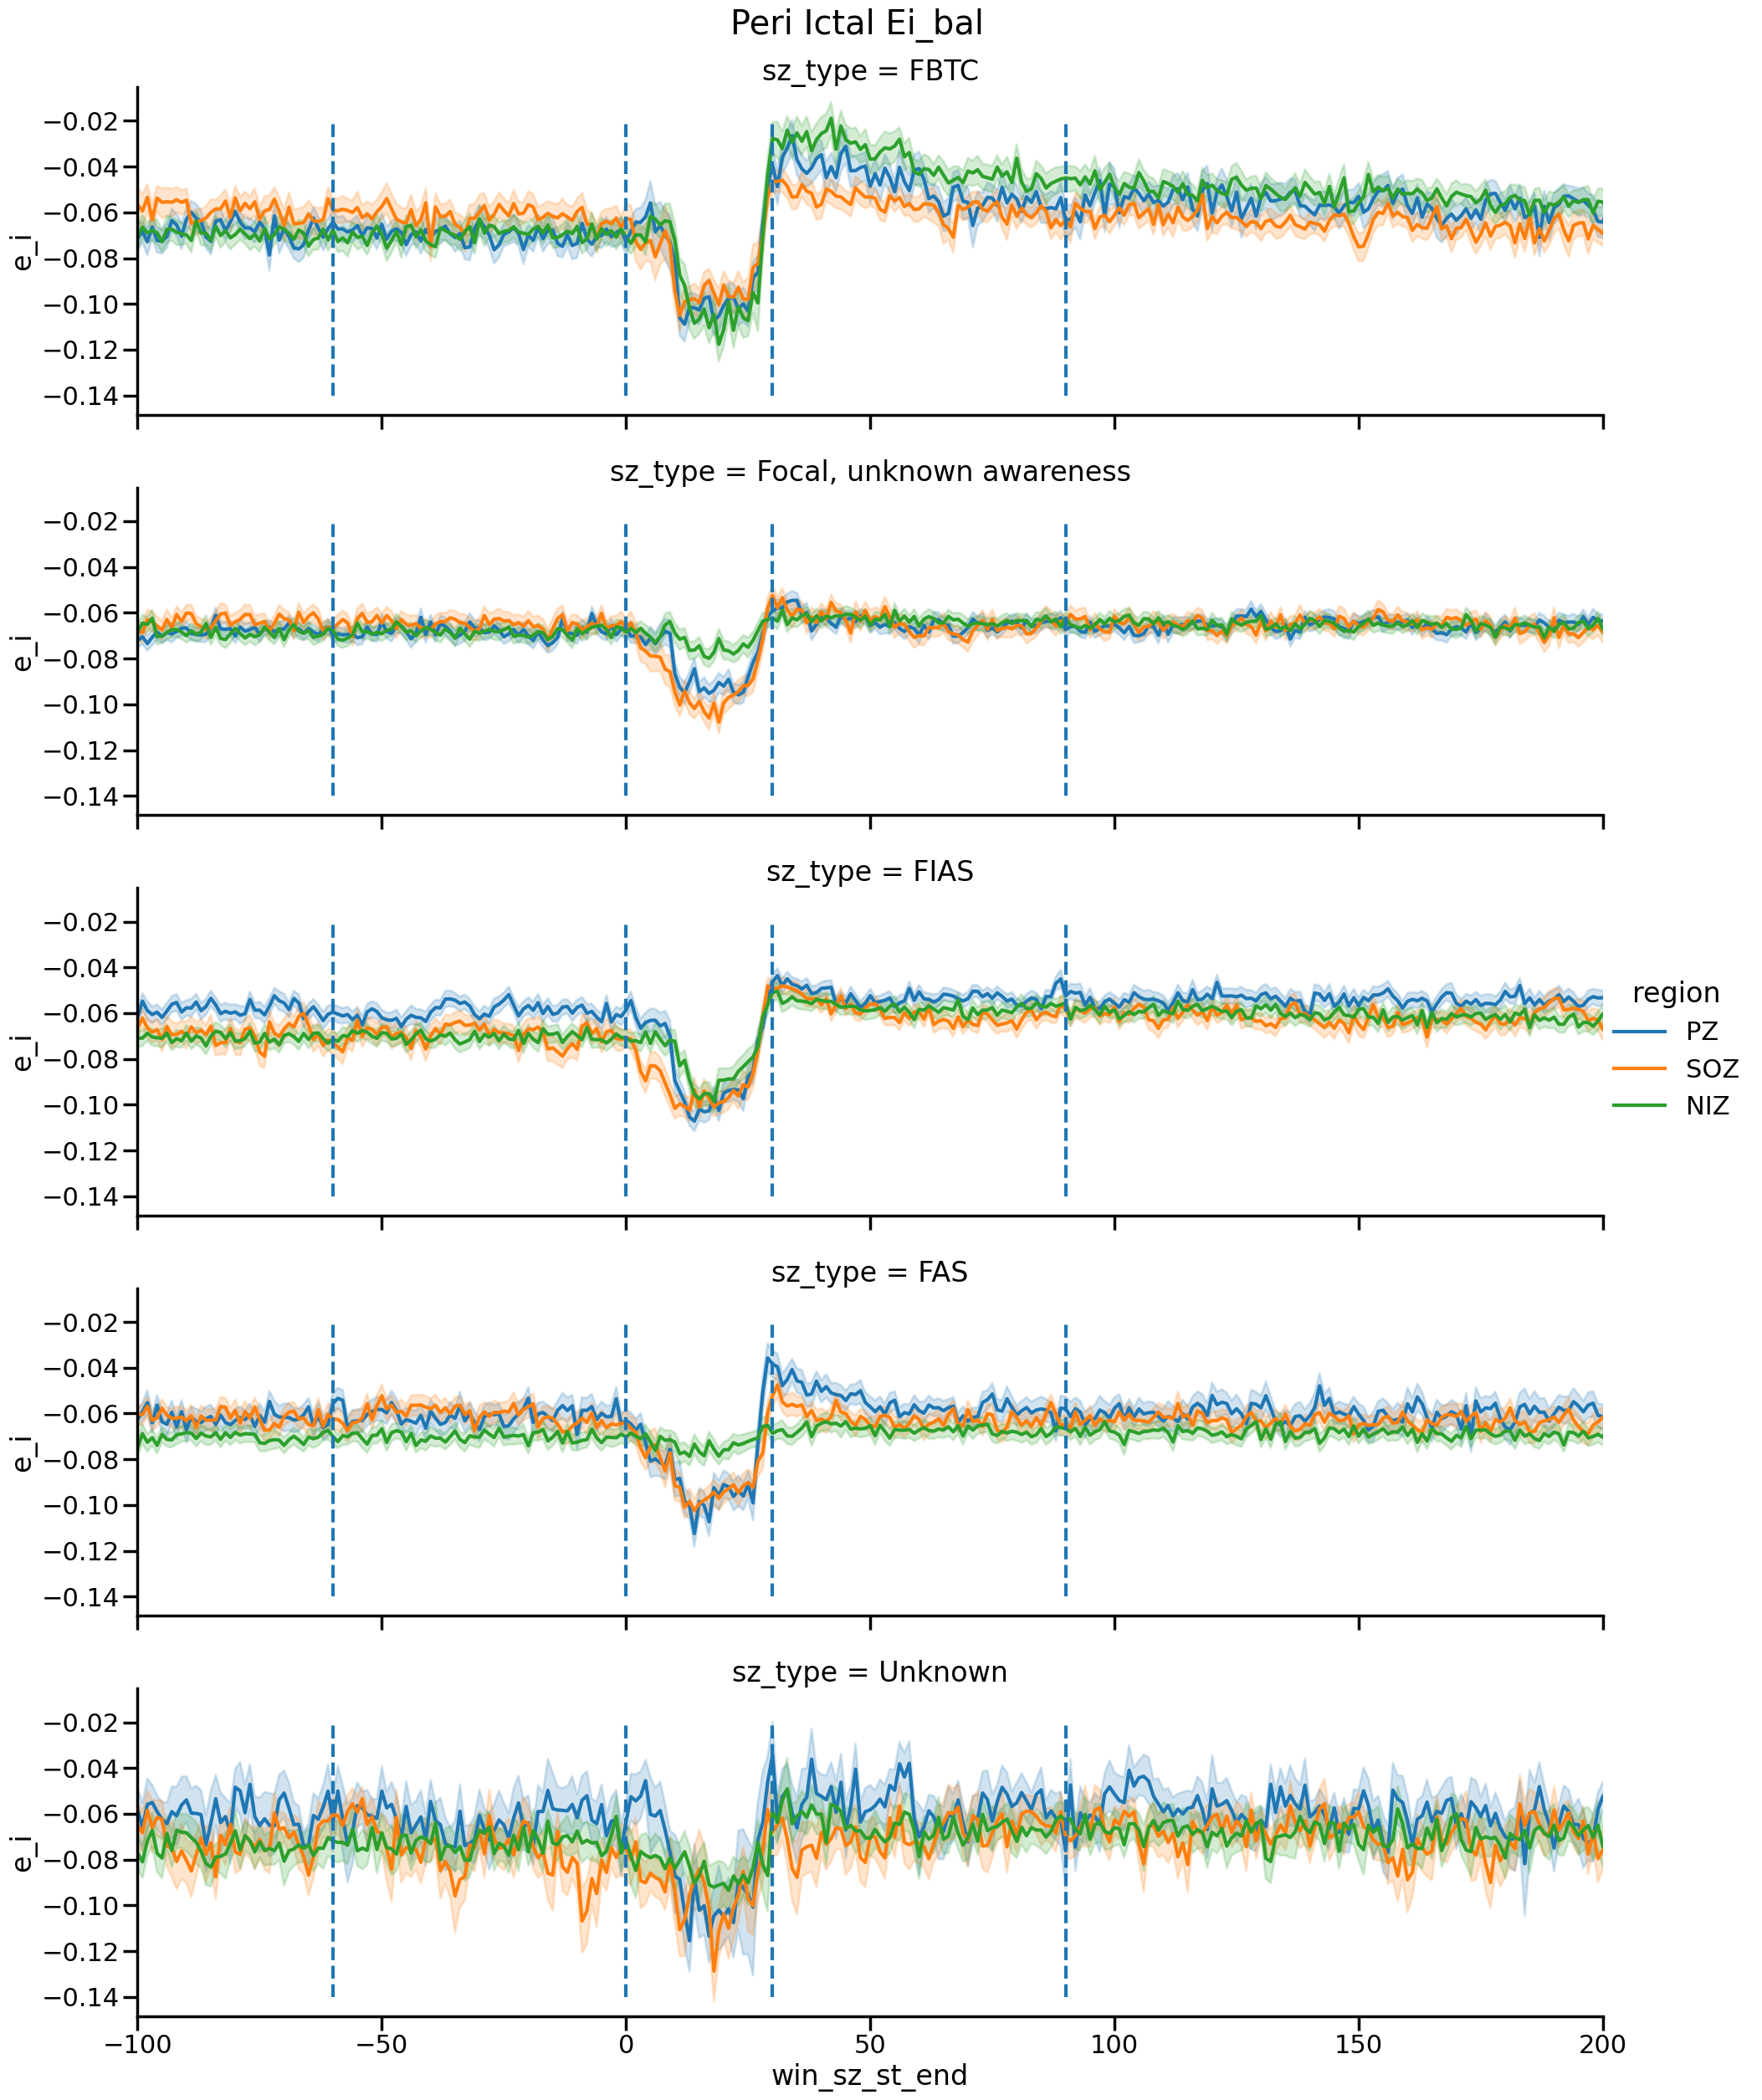

In [15]:
with sns.plotting_context("poster"):
    with sns.color_palette("tab10"):
        plot_df = resamp_dfs.dropna()
        #grid = sns.FacetGrid(plot_df, row='sz_type',aspect=4) 
        grid = sns.relplot(data= plot_df,
                           x='win_sz_st_end',
                           y="e_i",
                           row='sz_type',
                           hue='region',
                           aspect=4,
                           kind='line')
 #       grid.map_dataframe(sns.lineplot, y='e_i',x='win_sz_st_end', hue='region')
        #grid.add_legend()
        axes = grid.axes
        for ax in axes:
            ax[0].vlines(x = [-60,0, 30, 90], ymin = -.14, ymax = -.02,linestyles ='dashed')
        plt.xlim(-100, 200)
        grid.figure.suptitle("Peri Ictal Ei_bal",y=1.01)
        plt.savefig("../viz/peri_Epat_FULL_ei_bal.pdf",transparent=True)

In [ ]:
grp_df[['region','period','e_i']].groupby(['region','period']).mean()